![River-logo](river_logo.png)

# Introduction
## A complete stream learning experiment in 4 lines of code*

---

**Remember:** The standard machine learning approach assumes that **all** the data is available for training and data is processed in **batches**.

Let's see an example based on the [`Iris` dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) available in `scikit-learn`:

> This data set consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 `numpy.ndarray`

In [1]:
# Imports
from river import evaluate
from river import stream
from river import naive_bayes
from river import metrics

from sklearn.datasets import load_iris

The `progressive_val_score` method implements the **prequential evaluation** and requires three components: 

- a data stream
- a model
- a metric

In [2]:
# Setup stream and estimators
data = stream.iter_sklearn_dataset(load_iris(), shuffle=True, seed=42)
nb = naive_bayes.GaussianNB()
metric = metrics.Accuracy()

# Setup evaluator
evaluate.progressive_val_score(dataset=data, model=nb, metric=metric, print_every=10)

[10] Accuracy: 44.44%
[20] Accuracy: 73.68%
[30] Accuracy: 82.76%
[40] Accuracy: 84.62%
[50] Accuracy: 85.71%
[60] Accuracy: 88.14%
[70] Accuracy: 88.41%
[80] Accuracy: 89.87%
[90] Accuracy: 89.89%
[100] Accuracy: 90.91%
[110] Accuracy: 91.74%
[120] Accuracy: 92.44%
[130] Accuracy: 92.25%
[140] Accuracy: 92.81%
[150] Accuracy: 91.95%


Accuracy: 91.95%

### Under the hood

In the streaming setting, training and predicting happen inside a loop. Remember, a data sample is available only once in the stream.

The `iter_sklearn` method converts a `scikit-learn` dataset object into an iterable that returns the data as `dict`.

The following example shows the main steps performed by `progressive_val_score`:

In [3]:
model = naive_bayes.GaussianNB()
metric = metrics.Accuracy()
data = stream.iter_sklearn_dataset(load_iris(), shuffle=True, seed=42)

for x, y in data:
    y_pred = model.predict_one(x)                    # Predict class
    if y_pred is not None:
        metric.update(y_true=y, y_pred=y_pred)       # Update metric
    model.learn_one(x, y)                            # Train the model

print(f'[{metric.cm.n_samples + 1}] {metric}')

[150] Accuracy: 91.95%


### Order matters!

Notice the *order* of the training and prediction operations.

When a new data sample ($x_i$, $y_i$) arrives:

1. Predict the label $y_i'$ for the new data sample $x_i$, *not yet "seen"* by the model.
2. Train the model using the new sample ($x_i$, $y_i$).

### Important

- We use *all* labeled samples in the stream to measure a model's performance. 
- The model provides predictions at any point in the stream, according to its *current* internal state. Batch methods can only predict after they finished training.
- All methods (models, metrics, etc.) in `River` are updated **one sample at a time**

### Dictionaries

The default data structure used internally in `River`.

- Efficient storage of 1-dimensional data (1 sample)
- Supports sparse/missing data
- Easy access to features by name 

In [4]:
# Last sample from the experiment above
print(x, y)

{'sepal length (cm)': 6.1, 'sepal width (cm)': 2.9, 'petal length (cm)': 4.7, 'petal width (cm)': 1.4} 1


## Decision trees for data streams
---

### `NEWeather` data set

**Description:** The National Oceanic and Atmospheric Administration (NOAA),
has compiled a database of weather measurements from over 7,000 weather 
stations worldwide. Records date back to the mid-1900s. Daily measurements
include a variety of features (temperature, pressure, wind speed, etc.) as
well as a series of indicators for precipitation and other weather-related
events. The `NEweather` data set contains data from this database, specifically
from the Offutt Air Force Base in Bellevue, Nebraska ranging for over 50 years
(1949-1999).

**Features:** 8 Daily weather measurements
 
|       Attribute      | Description |
|:--------------------:|:-----------------------------|
| `temp`                   | Temperature
| `dew_pnt`                | Dew Point
| `sea_lvl_press`          | Sea Level Pressure
| `visibility`             | Visibility
| `avg_wind_spd`           | Average Wind Speed
| `max_sustained_wind_spd` | Maximum Sustained Wind Speed
| `max_temp`               | Maximum Temperature
| `min_temp`               | Minimum Temperature


**Class:** `rain` | 0: no rain, 1: rain
 
**Samples:** 18,159

---

In this example, we load the data from a csv file with `pandas.read_csv`. 

Next, we use the `iter_pandas` utility method to iterate over the `DataFrame`. The model in this example is a `HoeffdingTreeClassifier`, a type of decision tree designed for data streams.

In [5]:
import pandas as pd

from river import tree

df = pd.read_csv("NEweather.csv")
features = df.columns[:-2]
data = stream.iter_pandas(X=df[features], y=df['rain'])

model = tree.HoeffdingTreeClassifier()
metric = metrics.Accuracy()

evaluate.progressive_val_score(dataset=data,
                               model=model,
                               metric=metric,
                               print_every=1000)

[1,000] Accuracy: 71.57%
[2,000] Accuracy: 71.54%
[3,000] Accuracy: 71.86%
[4,000] Accuracy: 72.97%
[5,000] Accuracy: 73.13%
[6,000] Accuracy: 73.21%
[7,000] Accuracy: 73.88%
[8,000] Accuracy: 73.57%
[9,000] Accuracy: 73.70%
[10,000] Accuracy: 73.77%
[11,000] Accuracy: 74.15%
[12,000] Accuracy: 74.36%
[13,000] Accuracy: 74.53%
[14,000] Accuracy: 74.38%
[15,000] Accuracy: 74.57%
[16,000] Accuracy: 74.57%
[17,000] Accuracy: 74.46%
[18,000] Accuracy: 74.17%


Accuracy: 74.15%

- Tree-based models are popular due to their interpretability.
- They use a tree data structure to model the data.
- When a sample arrives, it traverses the tree until it reaches a leaf node.
- Internal nodes define the path for a data sample based on the values of its features.
- Leaf nodes are models that provide predictions for unlabeled-samples and can update their internal state using the labels from labeled samples.

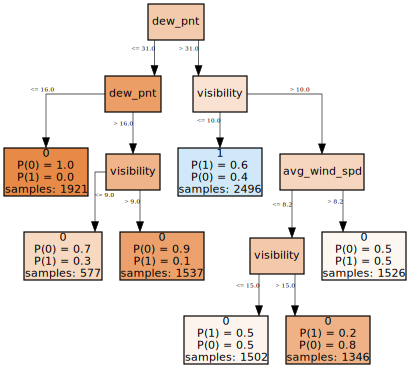

In [6]:
model.draw()

### Incremental tree growth

In [7]:
import itertools

data = stream.iter_pandas(X=df[features], y=df['rain'])
metric = metrics.Accuracy()

model = tree.HoeffdingTreeClassifier()

Running the following cell multiple times we can "see" the tree growing.

Accuracy: 71.50% - n_samples: 1000


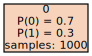

In [8]:
chunk = itertools.islice(data, 1000)     # Get chunks of data from the stream
for x, y in chunk:
    y_pred = model.predict_one(x)
    metric.update(y_true=y, y_pred=y_pred)
    model.learn_one(x, y)

print(f'{metric} - n_samples: {metric.cm.n_samples}')
model.draw()

## Pipelines
---

Pipelines are powerful tools that "chain" a sequence of operations. 

For example, the logistic regression model is sensitive to the scale of the features. Scaling the data so that each feature has mean $\mu=0$ and variance $\sigma^2=1$ is generally considered good practice.

We can apply the scaling and train the logistic regression sequentially in an elegant manner using a Pipeline.


In [9]:
from river import linear_model
from river import preprocessing
from river import compose

df = pd.read_csv("NEweather.csv")
features = df.columns[:-2]
data = stream.iter_pandas(X=df[features], y=df['rain'])

scaler = preprocessing.StandardScaler()
pipeline = compose.Pipeline(
    ('scale', preprocessing.StandardScaler()),
    ('log_reg', linear_model.LogisticRegression())
)

metric = metrics.Accuracy()

evaluate.progressive_val_score(dataset=data,
                               model=pipeline,
                               metric=metric,
                               print_every=1000)

[1,000] Accuracy: 74.80%
[2,000] Accuracy: 76.30%
[3,000] Accuracy: 77.63%
[4,000] Accuracy: 76.80%
[5,000] Accuracy: 76.60%
[6,000] Accuracy: 76.48%
[7,000] Accuracy: 76.97%
[8,000] Accuracy: 76.40%
[9,000] Accuracy: 76.27%
[10,000] Accuracy: 76.28%
[11,000] Accuracy: 76.50%
[12,000] Accuracy: 76.73%
[13,000] Accuracy: 76.50%
[14,000] Accuracy: 76.34%
[15,000] Accuracy: 76.43%
[16,000] Accuracy: 76.49%
[17,000] Accuracy: 76.29%
[18,000] Accuracy: 76.20%


Accuracy: 76.23%

We can visualize the pipeline.

In [10]:
pipeline

Pipeline (
  StandardScaler (),
  LogisticRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Log (
      weight_pos=1.
      weight_neg=1.
    )
    l2=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

## Regression
---

### Bike Sharing data set

Contains the **hourly and daily count of rental bikes** between the years 2011 and 2012 in the Capital bike-share system with the corresponding weather and seasonal information. Attributes include weather, temperature, date, time, etc.

|      Attribute      | Description |
|:-------------------:|:-----------------------------------------------------------------|
| `instant`             | record index
| `dteday`              | date
| `season`              | 1:winter<br>2:spring<br>3:summer<br>4:fall)
| `yr`                  | year (0: 2011, 1:2012)
| `mnth`                | month ( 1 to 12)
| `hr`                  | hour (0 to 23)
| `holiday`             | weather day is holiday or not
| `weekday`             | day of the week
| `workingday`          | if day is neither weekend nor holiday is 1, otherwise is 0.
| `weathersit`          | 1: Clear, Few clouds, Partly cloudy, Partly cloudy<br>2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
| `temp`                | Normalized temperature in Celsius.
| `atemp`               | Normalized feeling temperature in Celsius.
| `hum`                 | Normalized humidity.
| `windspeed`           | Normalized wind speed.
| `casual`              | count of casual users
| `registered`          | count of registered users

**Target:** `cnt` | number of bikes rented including both casual and registered
 
**Samples:** 17,389

For this example we will use the k-nearest neighbor algorithm. The target value for a query sample is estimated by aggregating the target values of the k-neighbors on a sliding window.

In [11]:
from river import neighbors

df = pd.read_csv("bike.csv")
features = df.columns[:-2]

data = stream.iter_pandas(X=df[features], y=df['cnt'])
model = neighbors.KNNRegressor(n_neighbors=3, window_size=100)
metric = metrics.R2()

evaluate.progressive_val_score(dataset=data,
                               model=model,
                               metric=metric,
                               print_every=1000)

[1,000] R2: 0.569228
[2,000] R2: 0.647591
[3,000] R2: 0.717623
[4,000] R2: 0.748093
[5,000] R2: 0.760055
[6,000] R2: 0.746103
[7,000] R2: 0.737243
[8,000] R2: 0.730013
[9,000] R2: 0.723937
[10,000] R2: 0.719661
[11,000] R2: 0.731367
[12,000] R2: 0.737862
[13,000] R2: 0.74638
[14,000] R2: 0.748483
[15,000] R2: 0.751023
[16,000] R2: 0.750326
[17,000] R2: 0.746482


R2: 0.74682

The k-nearest neighbor algorithm assumes that all the features are numeric.

In the `bike` data, there are some categorical features. We can easily filter them in a pipeline:

In [12]:
data = stream.iter_pandas(X=df[features], y=df['cnt'])
pipeline = (
    compose.Discard('season', 'mnth', 'weekday', 'weathersit') |
    neighbors.KNNRegressor(n_neighbors=3, window_size=100)
)
metric = metrics.R2()

evaluate.progressive_val_score(dataset=data,
                               model=pipeline,
                               metric=metric,
                               print_every=1000)

[1,000] R2: 0.723243
[2,000] R2: 0.744373
[3,000] R2: 0.77689
[4,000] R2: 0.823322
[5,000] R2: 0.832047
[6,000] R2: 0.819849
[7,000] R2: 0.81477
[8,000] R2: 0.80626
[9,000] R2: 0.800177
[10,000] R2: 0.79539
[11,000] R2: 0.803151
[12,000] R2: 0.801147
[13,000] R2: 0.806475
[14,000] R2: 0.814549
[15,000] R2: 0.8178
[16,000] R2: 0.815114
[17,000] R2: 0.813029


R2: 0.812576

In [13]:
pipeline

Pipeline (
  Discard (
    mnth
    season
    weathersit
    weekday
  ),
  KNNRegressor (
    n_neighbors=3
    window_size=100
    leaf_size=30
    p=2
    aggregation_method="mean"
  )
)

## Concept Drift
---

Dynamic environments are challenging for machine learning methods because data changes over time.

For this example, we will generate a synthetic data stream by concatenating data from 3 different distributions:
- $dist_a$: $\mu=0.8$, $\sigma=0.05$
- $dist_b$: $\mu=0.4$, $\sigma=0.02$
- $dist_c$: $\mu=0.6$, $\sigma=0.1$.

In [14]:
import numpy as np
from utils import plot_data

# Generate data for 3 distributions
random_state = np.random.RandomState(seed=42)
dist_a = random_state.normal(0.8, 0.05, 1000)
dist_b = random_state.normal(0.4, 0.02, 1000)
dist_c = random_state.normal(0.6, 0.1, 1000)

# Concatenate data to simulate a data stream with 2 drifts
data = np.concatenate((dist_a, dist_b, dist_c))


plot_data(dist_a, dist_b, dist_c)

Loading BokehJS ...

As observed above, the synthetic data stream has 3 **abrupt drifts**. An analogy could be trending topics on Twitter which can change quickly.

The goal is to detect that drift has occurred, after samples **1000** and **2000** in the synthetic data stream.

In this example, we will use the ADaptive WINdowing (`ADWIN`) drift detection method.



In [15]:
from river import drift

drift_detector = drift.ADWIN()
drifts = []

for i, val in enumerate(data):
    drift_detector.update(val)           # Data is processed one sample at a time
    if drift_detector.change_detected:
        print(f'Change detected at index {i}')
        drifts.append(i)
        drift_detector.reset()           # As a best practice, we reset the detector

plot_data(dist_a, dist_b, dist_c, drifts)

Change detected at index 1055
Change detected at index 2079


### Impact on predictive performance

Concept drift can negatively impact learning methods if not properly handled. Multiple real-world applications suffer **model degradation** as the models can not adapt to changes in the data.

In this example, we will use two popular streaming models:

1. The `Hoeffding Tree`
2. The `Hoeffding Adaptive Tree`

The `Hoeffding Adaptive Tree` uses `ADWIN` to detect changes. If change is detected in a given branch, an alternate branch is created and eventually replaces the original branch if it shows better performance on new data.

---
### `AGRAWAL` dataset

We will load the data from a csv file. The data was generated using the `AGRAWAL` data generator with 3 **gradual drifts** at the 5k, 10k, and 15k marks.

The `AGRAWAL` synthetic data generator produces 9 features, 6 numeric and 3 categorical.

There are 10 functions for generating binary class labels from the features. These functions determine whether a **loan** should be approved.

| Feature    | Description            | Values                                                                |
|------------|------------------------|-----------------------------------------------------------------------|
| `salary`     | salary                 | uniformly distributed from 20k to 150k                                |
| `commission` | commission             | if (salary <   75k) then 0 else uniformly distributed from 10k to 75k |
| `age`        | age                    | uniformly distributed from 20 to 80                                   |
| `elevel`     | education level        | uniformly chosen from 0 to 4                                          |
| `car`        | car maker              | uniformly chosen from 1 to 20                                         |
| `zipcode`    | zip code of the town   | uniformly chosen from 0 to 8                                          |
| `hvalue`     | value of the house     | uniformly distributed from 50k x zipcode to 100k x zipcode            |
| `hyears`     | years house owned      | uniformly distributed from 1 to 30                                    |
| `loan`       | total loan amount      | uniformly distributed from 0 to 500k                                  |

**Class:** `y` | 0: no loan, 1: loan
 
**Samples:** 20,000

`elevel`, `car`, and `zipcode` are categorical features.

In [16]:
df = pd.read_csv("agr_a_20k.csv")
features = df.columns[:-2]

data = stream.iter_pandas(X=df[features], y=df['class'])
model = tree.HoeffdingTreeClassifier(nominal_attributes=['elevel', 'car', 'zipcode'])
metric = metrics.Accuracy()

evaluate.progressive_val_score(dataset=data,
                               model=model,
                               metric=metric,
                               show_memory=True,
                               print_every=1000)

[1,000] Accuracy: 82.48% – 7.12 KB
[2,000] Accuracy: 82.89% – 51.01 KB
[3,000] Accuracy: 84.96% – 51.01 KB
[4,000] Accuracy: 86.50% – 51.01 KB
[5,000] Accuracy: 87.16% – 54.97 KB
[6,000] Accuracy: 80.85% – 63.19 KB
[7,000] Accuracy: 76.93% – 63.19 KB
[8,000] Accuracy: 74.75% – 77.83 KB
[9,000] Accuracy: 74.20% – 105.91 KB
[10,000] Accuracy: 74.49% – 120.97 KB
[11,000] Accuracy: 73.64% – 145.17 KB
[12,000] Accuracy: 73.57% – 148.46 KB
[13,000] Accuracy: 73.92% – 149.2 KB
[14,000] Accuracy: 74.65% – 156.38 KB
[15,000] Accuracy: 75.62% – 164.47 KB
[16,000] Accuracy: 74.25% – 194.02 KB
[17,000] Accuracy: 73.27% – 196.38 KB
[18,000] Accuracy: 72.83% – 197.65 KB
[19,000] Accuracy: 72.51% – 198.4 KB
[20,000] Accuracy: 72.37% – 214.21 KB


Accuracy: 72.37%

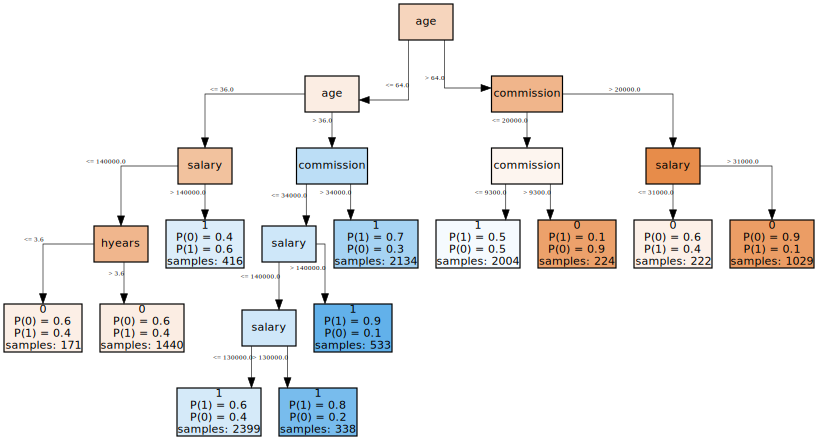

In [17]:
model.draw()

In [18]:
df = pd.read_csv("agr_a_20k.csv")
features = df.columns[:-2]

data = stream.iter_pandas(X=df[features], y=df['class'])
model = tree.HoeffdingAdaptiveTreeClassifier(nominal_attributes=['elevel', 'car', 'zipcode'], seed=42)
metric = metrics.Accuracy()

evaluate.progressive_val_score(dataset=data,
                               model=model,
                               metric=metric,
                               show_memory=True,
                               print_every=1000)

[1,000] Accuracy: 83.78% – 59.99 KB
[2,000] Accuracy: 87.54% – 66.63 KB
[3,000] Accuracy: 88.83% – 67.48 KB
[4,000] Accuracy: 90.15% – 67.65 KB
[5,000] Accuracy: 90.62% – 72.01 KB
[6,000] Accuracy: 84.40% – 26.76 KB
[7,000] Accuracy: 81.18% – 48.15 KB
[8,000] Accuracy: 79.23% – 50.22 KB
[9,000] Accuracy: 78.06% – 71.36 KB
[10,000] Accuracy: 76.93% – 109.41 KB
[11,000] Accuracy: 75.13% – 416.32 KB
[12,000] Accuracy: 74.31% – 434.49 KB
[13,000] Accuracy: 74.85% – 445.79 KB
[14,000] Accuracy: 75.30% – 471.49 KB
[15,000] Accuracy: 75.86% – 488.35 KB
[16,000] Accuracy: 74.80% – 26.79 KB
[17,000] Accuracy: 74.85% – 50.11 KB
[18,000] Accuracy: 75.14% – 72.78 KB
[19,000] Accuracy: 75.41% – 131.58 KB
[20,000] Accuracy: 75.61% – 137.31 KB


Accuracy: 75.61%

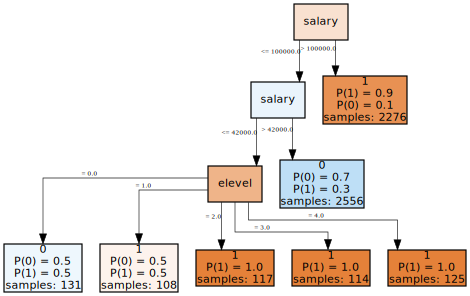

In [19]:
model.draw()